In [40]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
def batch_results(outputs):
    batch_errors = [x['error'] for x in outputs]
    mean_error_batch = torch.stack(batch_errors).mean()
    batch_acc = [x['acc'] for x in outputs]
    mean_acc = torch.stack(batch_acc).mean()
    return {"error": mean_error_batch.item(),"acc": mean_acc.item()}

In [4]:
batch_size = 32

In [5]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [6]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [70]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class ImageClassifier:
    def __init__(self, model_path,class_map_path,device='cpu'):
        self.device = device
        # Revisar si CUDA está disponible
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        
        # Cargar el modelo
        # self.model = torch.load(model_path, map_location=self.device)
        self.model = models.shufflenet_v2_x1_0(weights='ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1')
        for param in self.model.parameters():
            param.requires_grad = False

        with open(class_map_path) as f:
            self.classes = [line.strip() for line in f.readlines()]

      

        self.model.fc = nn.Linear(1024, len(self.classes))
        self.model = to_device(self.model, self.device)

        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        
        # Configurar la transformación de las imágenes
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

       
            # print(self.classes)
    
    def predict(self, image_path):
        # Cargar la imagen
        image = Image.open(image_path)
        image_tensor = self.transform(image).unsqueeze(0)
        x = to_device(image_tensor, self.device)
        output = self.model(x) 
        _,pred = torch.max(output,dim=1)
        print(pred[0].item())
        return self.classes[pred[0].item()]

In [32]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [57]:
image_path = 'data/test/Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED/IMG_5478.jpg'
model_path = 'db/model.pth'
class_map_path = 'db/classes.txt'
device =  get_default_device()

In [58]:
@torch.no_grad()
def evaluate(model,val_loader,output=False):
    model.eval()
    outputsBatch = []
    outputArray = {
      'predicted': [],
      'labels': [],
    }
    for batch in val_loader:
      images,labels= batch
      outputs=model(images)
      loss = F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, dim=1)
      correct = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
      outputsBatch.append({"error": loss.detach(),"acc": correct })
      if(output):
        outputArray['predicted'].extend(predicted.detach().cpu().numpy())
        outputArray['labels'].extend(labels.detach().cpu().data.numpy())
    if(output):
        resOuput = batch_results(outputsBatch)
        resOuput['outputs'] = outputArray
        return resOuput

In [59]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [60]:
test_dataset = datasets.ImageFolder('data/test', transform=train_transforms)
# Crear el iterador para recorrer los datos de prueba en lotes
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
TEST_DATA_DL = DeviceDataLoader(test_loader, device)

In [71]:
classifier = ImageClassifier(model_path, class_map_path, 'cpu')
predicted_class = classifier.predict(image_path)
print(predicted_class)

15
Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED


In [68]:
resultsTest = evaluate(classifier.model, TEST_DATA_DL, True)
print("Error:",resultsTest['error'], "Accuracy:",resultsTest['acc'])

Error: 1.760452389717102 Accuracy: 0.699999988079071


In [63]:
def predict(model,img,classes,device,to_device):
    x = to_device(img.unsqueeze(0),device)
    output = model(x)
    _,pred = torch.max(output,dim=1)
    print(pred[0].item())
    return classes[pred[0].item()]

In [64]:
print(test_dataset.classes)

['Berchtold_Marvelle3.20.23Rack1-11_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-14_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-7_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_7_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_9_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_10_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_16_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_21_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_22_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_23_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_24_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_25_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_26_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_27', 'Schwartz_Jodi3.21.23_lgorbitvu_29_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED', 'Vultaggio_Wesley3.16.23Rack2-24', 'Vultaggio_Wesley3.16.23Rack2-26', 'Vultaggio_Wesley3.16.23Rack2-4']


In [44]:
import numpy as np

# Supongamos que el arreglo que deseas guardar se llama 'arreglo'
np.savetxt('nombre_del_archivo.txt', test_dataset.classes, fmt='%s')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
Label: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED , Predicted: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED


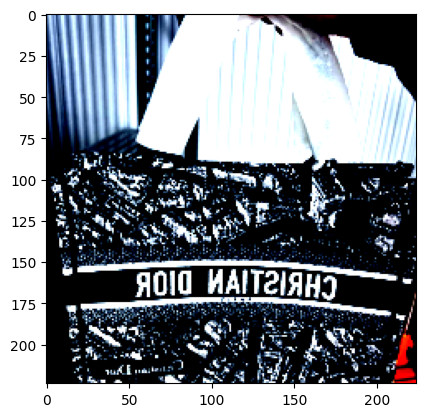

In [69]:

img1,label1= test_dataset[23]
plt.imshow(img1.permute(1, 2, 0))
print('Label:', test_dataset.classes[label1], ', Predicted:', predict(classifier.model,img1,test_dataset.classes,device,to_device))


In [53]:
image_path = 'data/test/Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED/IMG_5478.jpg'

In [66]:
classifier = ImageClassifier(model_path, class_map_path, 'cpu')
predicted_class = classifier.predict(image_path)
print(predicted_class)

3
Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_7_BATCHED
